In [ ]:
#### import numpy as np
import sympy as sym
%pylab inline
from wingstructure.structure2 import SectionBase, Layer, BoxSpar
from wingstructure.material import IsotropicMaterial as Material

# Spannungs- und Dehnungsverlauf im Querschnitt infolge Querkraft und Moment
## Modell: Flügelgeometrie aus mehreren Schalen (1x Außenlage, 2x Innenlage, 4x Holmteile)
Autor: Simeon "Moni" Gubernator

## 0. Formeln und Funktionen definieren

### 0.0 Literatur:
Dankert, Jürgen/Dankert, Helga (2013). Technische Mechanik. Statik, Festigkeitslehre, Kinematik/Kinetik, Wiesbaden.

### 0.1 Flächenkennwerte einer von einem geschlossenen Polygonzug begrenzten Fläche

$ A = \frac{1}{2} \sum_{i} \left( \bar y_{i+1} \bar x_i - \bar y_{i} \bar x_{i+1} \right) $

$ S_\bar x = \frac{1}{6} \sum_{i} \left( \bar y_{i} + \bar y_{i+1} \right) \left( \bar y_{i+1} \bar x_i - \bar y_{i} \bar x_{i+1} \right) $

$ S_\bar y = \frac{1}{6} \sum_{i} \left( \bar x_{i} + \bar x_{i+1} \right) \left( \bar y_{i+1} \bar x_i - \bar y_{i} \bar x_{i+1} \right) $

$ I_{\bar x \bar x} = \frac{1}{12} \sum_{i} \left[ \bar y_{i+1}^2 + \left( \bar y_{i} + \bar y_{i+1} \right) \bar y_{i} \right] \left( \bar y_{i+1} \bar x_i - \bar y_{i} \bar x_{i+1} \right) $

$ I_{\bar y \bar y} = \frac{1}{12} \sum_{i} \left[ \bar x_{i+1}^2 + \left( \bar x_{i} + \bar x_{i+1} \right) \bar x_{i} \right] \left( \bar y_{i+1} \bar x_i - \bar y_{i} \bar x_{i+1} \right) $

$ I_{\bar x \bar y} = \frac{1}{12} \sum_{i} \left[ \frac{1}{2} \bar x_{i+1}^2 \bar y_{i}^2 - \frac{1}{2} \bar x_{i}^2 \bar y_{i+1}^2 - \left( \bar y_{i+1} \bar x_i - \bar y_i \bar x_{i+1} \right) \left( \bar x_i \bar y_i + \bar x_{i+1} \bar y_{i+1} \right)  \right] $

### 0.2 Koordinaten des Schwerpunkts

$ \bar x_S = \frac{S_\bar y}{A} $

$ \bar y_S = \frac{S_\bar x}{A} $

### 0.3 Flächenträgheitsmomente bezüglich des Schwerpunkt-Koordinatensystems

$ I_{xx} = I_{\bar x \bar x} - \bar y_S^2 A $

$ I_{yy} = I_{\bar y \bar y} - \bar x_S^2 A $

$ I_{xy} = I_{\bar x \bar y} + \bar x_S \bar y_S A $

In [2]:
def fläche_polygon(polygon):

    A = 0

    for i in range(0,len(polygon)-1):
        a = polygon[i]
        b = polygon[i+1]
    
        A += 1/2 * (b[1]*a[0] - a[1]*b[0])
    
    return A
    
    
def fläche_schale(schale):

    polygon_außen = schale["außen"]
    polygon_innen = schale["innen"]
    
    A_außen = fläche_polygon(polygon_außen)
    A_innen = fläche_polygon(polygon_innen)
    
    A = A_außen - A_innen
    
    return A
    
    
def statische_momente_polygonfläche(polygon):

    S_x = 0
    S_y = 0

    for i in range(0,len(polygon)-1):
        a = polygon[i]
        b = polygon[i+1]
    
        S_x += 1/6 * (a[1] + b[1]) * (b[1]*a[0] - a[1]*b[0])
        S_y += 1/6 * (a[0] + b[0]) * (b[1]*a[0] - a[1]*b[0])

    return S_x, S_y


def statische_momente_schale(schale):
        
    polygon_außen = schale["außen"]
    polygon_innen = schale["innen"]
    
    S_x_außen, S_y_außen = statische_momente_polygonfläche(polygon_außen)
    S_x_innen, S_y_innen = statische_momente_polygonfläche(polygon_innen)
    
    S_x = S_x_außen - S_x_innen
    S_y = S_y_außen - S_y_innen

    return S_x, S_y

    
def schwerpunkt_polygonfläche(polygon):

    A = fläche_polygon(polygon)
    S_x, S_y = statische_momente_polygonfläche(polygon)
    
    x_S = S_y/A
    y_S = S_x/A
    
    return x_S, y_S
    
    
def schwerpunkt_schale(schale):

    A = fläche_schale(schale)
    S_x, S_y = statische_momente_schale(schale)
    
    x_S = S_y/A
    y_S = S_x/A
    
    return x_S, y_S


def flächenträgheitsmomente_polygonfläche_bzgl_ursprung(polygon):

    I_xx = 0
    I_yy = 0
    I_xy = 0

    for i in range(0,len(polygon)-1):
        a = polygon[i]
        b = polygon[i+1]
    
        I_xx += 1/12 * (b[1]**2 + (a[1] + b[1])*a[1]) * (b[1]*a[0] - a[1]*b[0])
        I_yy += 1/12 * (b[0]**2 + (a[0] + b[0])*a[0]) * (b[1]*a[0] - a[1]*b[0])
        I_xy += 1/12 * (0.5*b[0]**2 * a[1]**2 - 0.5*a[0]**2 * b[1]**2 - (b[1]*a[0] - a[1]*b[0]) * (a[0]*a[1] - b[0]*b[1]))

    return I_xx, I_yy, I_xy
        
        
def flächenträgheitsmomente_schale_bzgl_ursprung(schale):

    polygon_außen = schale["außen"]
    polygon_innen = schale["innen"]
    
    I_xx_außen, I_yy_außen, I_xy_außen = flächenträgheitsmomente_polygonfläche_bzgl_ursprung(polygon_außen)
    I_xx_innen, I_yy_innen, I_xy_innen = flächenträgheitsmomente_polygonfläche_bzgl_ursprung(polygon_innen)
        
    I_xx = I_xx_außen - I_xx_innen
    I_yy = I_yy_außen - I_yy_innen
    I_xy = I_xy_außen - I_xy_innen 
        
    return I_xx, I_yy, I_xy
    
    
def flächenträgheitsmomente_polygonfläche_bzgl_schwerpunkt(polygon):
    
    A = fläche_polygon(polygon)
    I_xx, I_yy, I_xy = flächenträgheitsmomente_polygonfläche_bzgl_ursprung(polygon)
    x_S, y_S = schwerpunkt_polygonfläche(polygon)
    
    I_xx_SP = I_xx - y_S**2*A
    I_yy_SP = I_yy - x_S**2*A
    I_xy_SP = I_xy + x_S*y_S*A

    return I_xx_SP, I_yy_SP, I_xy_SP
    
    
def flächenträgheitsmomente_schale_bzgl_schwerpunkt(schale):
    
    A = fläche_schale(schale)
    I_xx, I_yy, I_xy = flächenträgheitsmomente_schale_bzgl_ursprung(schale)
    statische_momente = statische_momente_schale(schale)
    x_S, y_S = schwerpunkt_schale(A, statische_momente)
    
    I_xx_SP = I_xx - y_S**2*A
    I_yy_SP = I_yy - x_S**2*A
    I_xy_SP = I_xy + x_S*y_S*A

    return I_xx_SP, I_yy_SP, I_xy_SP


def flächenträgheitsmomente_polygonfläche_bzgl_NC(polygon):

    I_xx = 0
    I_yy = 0
    I_xy = 0

    for i in range(0,len(polygon)-1):
        a = polygon[i] - NC
        b = polygon[i+1] - NC
    
        I_xx += 1/12 * (b[1]**2 + (a[1] + b[1])*a[1]) * (b[1]*a[0] - a[1]*b[0])
        I_yy += 1/12 * (b[0]**2 + (a[0] + b[0])*a[0]) * (b[1]*a[0] - a[1]*b[0])
        I_xy += 1/12 * (0.5*b[0]**2 * a[1]**2 - 0.5*a[0]**2 * b[1]**2 - (b[1]*a[0] - a[1]*b[0]) * (a[0]*a[1] - b[0]*b[1]))

    return I_xx, I_yy, I_xy


def flächenträgheitsmomente_schale_bzgl_NC(schale):
    
    polygon_außen = schale["außen"]
    polygon_innen = schale["innen"]
    
    I_xx_außen, I_yy_außen, I_xy_außen = flächenträgheitsmomente_polygonfläche_bzgl_NC(polygon_außen)
    I_xx_innen, I_yy_innen, I_xy_innen = flächenträgheitsmomente_polygonfläche_bzgl_NC(polygon_innen)
        
    I_xx = I_xx_außen - I_xx_innen
    I_yy = I_yy_außen - I_yy_innen
    I_xy = I_xy_außen - I_xy_innen 
        
    return I_xx, I_yy, I_xy

### 0.4 Literatur:
Hartsuijker, Coen/Welleman, Hans (2017): Structural Mechanics 4. Module: Non-symmetrical and inhomogeneous cross sections, Delft.

Da der E-Modul über die einzelnen Flächen konstant ist, gilt:

$ EA = \int_{A} E \left( y,z \right) dA = \sum_{i} \int_{A_i} E_i dA = \sum_{i} E_i \int_{A_i} dA = \sum_{i} E_i A_i $

$ ES_y = \int_{A} E \left( y,z \right) y dA = \sum_{i} \int_{A_i} E_i y dA = \sum_{i} E_i \int_{A_i} y dA = \sum_{i} E_i S_{yi} $

$ ES_z = \int_{A} E \left( y,z \right) z dA = \sum_{i} \int_{A_i} E_i z dA = \sum_{i} E_i \int_{A_i} z dA = \sum_{i} E_i S_{zi} $

$ EI_{yy} = \int_{A} E \left( y,z \right) y^2 dA = \sum_{i} \int_{A_i} E_i y^2 dA = \sum_{i} E_i \int_{A_i} y^2 dA = \sum_{i} E_i I_{yyi} $

$ EI_{zz} = \int_{A} E \left( y,z \right) z^2 dA = \sum_{i} \int_{A_i} E_i z^2 dA = \sum_{i} E_i \int_{A_i} z^2 dA = \sum_{i} E_i I_{zzi} $

$ EI_{yz} = \int_{A} E \left( y,z \right) y z dA = \sum_{i} \int_{A_i} E_i y z dA = \sum_{i} E_i \int_{A_i} y z dA = \sum_{i} E_i I_{yzi} $

### 0.5 Localise normal center (NC)

$ \bar y_{NC} = \frac{E S_\bar y}{E A} $

$ \bar z_{NC} = \frac{E S_\bar z}{E A} $

In [3]:
def ES_schalenmodell(emoduln_der_schalen, statische_momente_der_schalen):

    ESi = [x[0]*x[1] for x in zip(emoduln_der_schalen, statische_momente_der_schalen)]
    ES = np.add.reduce(ESi)
    return ES


def EA_schalenmodell(emoduln_der_schalen, flächen_der_schalen):

    EAi = emoduln_der_schalen*flächen_der_schalen
    EA = np.add.reduce(EAi)
    return EA


def EI_schalenmodell(emoduln_der_schalen, flächenträgheitsmomente_der_schalen):
    
    EIi = [x[0]*x[1] for x in zip(emoduln_der_schalen, flächenträgheitsmomente_der_schalen)]
    EI = np.add.reduce(EIi)
    return EI


def normal_center(ES, EA):

    NC = ES/EA
    NC = np.flip(NC, 0)
    return NC

### 0.6 Cross sectional deformations

$ \begin{bmatrix} N \\ M_y \\ M_z \end{bmatrix} =
\begin{bmatrix} EA & 0 & 0 \\ 0 & EI_{yy} & EI_{yz} \\ 0 & EI_{zy} & EI_{zz} \end{bmatrix}
\begin{bmatrix} \epsilon \\ \kappa_y \\ \kappa_z \end{bmatrix}
$

In [4]:
def deformations(forces, EA, EI):

    deformations = []

    for i in range(0,len(forces)):

        EI_xx = EI[0] # müssen noch für die anderen Schnittstellen berechnet werden
        EI_yy = EI[1]
        EI_xy = EI[2]

        matrix = np.matrix([[EA, 0, 0], [0, EI_xx, EI_xy], [0, EI_xy, EI_yy]])

        x = np.linalg.solve(matrix, forces[i]) # ϵ, κ_x, κ_y
        deformations.append(x)
    return deformations

### 0.7 Strain distribution

$ \epsilon \left( y,z \right) = \epsilon + y \kappa_y + z \kappa_z $

In [5]:
def strain_distribution(coords):

    matrix = np.matrix([[1], [coords[0]], [coords[1]]])

    ϵ = deformations(forces, EA, EI)*matrix
    
    return ϵ

### 0.8 Stress distribution

$ \sigma \left( y,z \right) = E \left( y,z \right) \epsilon \left( y,z \right) $

## 1. Werkstoffe definieren

In [6]:
balsa_schwer = Material(ρ=0.3e3, E=210e3, G=80e3)
balsa_mittel = Material(ρ=0.18e3, E=210e3, G=80e3)
balsa_leicht = Material(ρ=0.16e3, E=210e3, G=80e3)
gfk_rovings  = Material(ρ=1.225, E=210e3, G=80e3)
gfk_gewebe   = Material(ρ=1.225, E=210e3, G=80e3)

## 2. Geometrie definieren

### 2.1 Profilkoordinaten einlesen

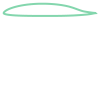

In [7]:
coords = np.loadtxt('AH_93_K_132_15.dat', skiprows=1)*1.2
sektion = SectionBase(coords)
sektion

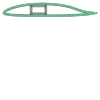

In [8]:
außenlage = Layer(sektion, gfk_gewebe, 3e-3)
kastenholm = BoxSpar(außenlage, {'flange': gfk_rovings, 'web': balsa_mittel},
                                0.45, 0.200, 3e-2, 1e-2)
innenlage = Layer(kastenholm, balsa_schwer, 3e-3)
sektion

## 3. Berechnung durchführen

### Berechnung EA, ES, EI, NC

In [9]:
# Daten aufbereiten, sodass Laufrichtung gegen Uhrzeigersinn

außenlage_exterior = außenlage.geometry.exterior.coords[:]
außenlage_exterior.reverse()

außenlage_interior = außenlage.geometry.interiors[0].coords[:]

innenlage_vorne = innenlage.geometry.geoms[0].exterior.coords[:]
innenlage_vorne.reverse()

innenlage_hinten = innenlage.geometry.geoms[1].exterior.coords[:]
innenlage_hinten.reverse()

holmsteg_rechts = kastenholm.geometry.geoms[0].exterior.coords[:]
holmsteg_rechts.reverse()

holmsteg_links = kastenholm.geometry.geoms[1].exterior.coords[:]
holmsteg_links.reverse()

holmgurt_unten = kastenholm.geometry.geoms[2].exterior.coords[:]
holmgurt_unten.reverse()

holmgurt_oben = kastenholm.geometry.geoms[3].exterior.coords[:]
holmgurt_oben.reverse()

außenlage = {"außen": außenlage_exterior,
            "innen": außenlage_interior}

In [10]:
emoduln_der_schalen = np.array([70e3, 70e3, 70e3, 210e3, 210e3, 1400e3, 1400e3]) # random

statische_momente_der_schalen = np.array([statische_momente_schale(außenlage),
                                          statische_momente_polygonfläche(innenlage_vorne),
                                          statische_momente_polygonfläche(innenlage_hinten),
                                          statische_momente_polygonfläche(holmsteg_rechts),
                                          statische_momente_polygonfläche(holmsteg_links),
                                          statische_momente_polygonfläche(holmgurt_oben),
                                          statische_momente_polygonfläche(holmgurt_unten)])

flächen_der_schalen = np.array([fläche_schale(außenlage),
                                fläche_polygon(innenlage_vorne),
                                fläche_polygon(innenlage_hinten),
                                fläche_polygon(holmsteg_rechts),
                                fläche_polygon(holmsteg_links),
                                fläche_polygon(holmgurt_oben),
                                fläche_polygon(holmgurt_unten)])

ES = ES_schalenmodell(emoduln_der_schalen, statische_momente_der_schalen)

EA = EA_schalenmodell(emoduln_der_schalen, flächen_der_schalen)

NC = normal_center(ES, EA)
NC = np.flip(NC,0)

flächenträgheitsmomente_der_schalen = np.array([flächenträgheitsmomente_schale_bzgl_NC(außenlage),
                                                flächenträgheitsmomente_polygonfläche_bzgl_NC(innenlage_vorne),
                                                flächenträgheitsmomente_polygonfläche_bzgl_NC(innenlage_hinten),
                                                flächenträgheitsmomente_polygonfläche_bzgl_NC(holmsteg_rechts),
                                                flächenträgheitsmomente_polygonfläche_bzgl_NC(holmsteg_links),
                                                flächenträgheitsmomente_polygonfläche_bzgl_NC(holmgurt_oben),
                                                flächenträgheitsmomente_polygonfläche_bzgl_NC(holmgurt_unten)])

EI = EI_schalenmodell(emoduln_der_schalen, flächenträgheitsmomente_der_schalen)

### Eingabe von N, Q, M

In [11]:
# von Garfield, Momentenverlauf aus Auftriebsverteilung

π = sym.pi
A = 1
b = 15 #half span
ys = np.linspace(0.0, b/2-1e-5, 400)

y = sym.symbols('y')
dA_dy = sym.sqrt((A/(π*b) * (1-4*y**2/b**2)))

dA_dy_fun = sym.lambdify(y, dA_dy,'numpy')
dA_dy_num = dA_dy_fun(ys)

from scipy.integrate import cumtrapz

Q_num = cumtrapz(dA_dy_num[::-1], ys[::-1], initial=0)[::-1]

M_num = cumtrapz(Q_num[::-1], ys[::-1], initial=0)[::-1]

N = np.zeros(400)
M_x = M_num
M_y = np.zeros(400)
Q_y = np.zeros(400)
Q_z = Q_num

shear_force = np.array([Q_y, Q_z]).T

forces = np.array([N, M_x, M_y]).T

### Dehnungsvektor berechnen

In [16]:
deformations_schalenmodell = deformations(forces, EA, EI)

### Dehnung in x-Richtung in Abhängigkeit der Koordinaten

In [17]:
coords = [0.1, 0.2]

ϵ = strain_distribution(coords)

### Normalspannung an dieser Stelle

In [14]:
E = emoduln_der_schalen[0]

σ = E*ϵ